# Run the cycle step by step

**Useful quantities:**
- L:
    1mm = 5068eV
- Temperature:
    10^3K = 0.0862eV
- Frequency:
    1MHz = 4.13e-9eV ,
    10GHz = 10000MHz = 4.13e-5

In [1]:
using Revise
using CSV
using DataFrames
using TOML
using Serialization

using QuantumToolbox

using ProgressBars
using ProgressMeter

using LinearAlgebra
using SparseArrays
# Solve ODE
using DifferentialEquations

using Plots
using LaTeXStrings

In [ ]:
includet("./modules/OpticalCavity.jl")
includet("./modules/Thermodynamics.jl")
includet("./modules/MasterEquations.jl")
includet("./modules/Phaseonium.jl")
includet("./modules/BosonicOperators.jl")
includet("./modules/Measurements.jl")
include("./src/Strokes.jl")

using .OpticalCavity
using .Thermodynamics
using .MasterEquations
using .Phaseonium
using .BosonicOperators
using .Measurements
using .Strokes

includet("./src/RoutineFunctions.jl")

┌ Warning: Replacing docs for `BosonicOperators :: Union{}` in module `Main.BosonicOperators`
└ @ Base.Docs docs/Docs.jl:243
┌ Warning: Replacing docs for `Measurements :: Union{}` in module `Main.Measurements`
└ @ Base.Docs docs/Docs.jl:243
┌ Warning: Replacing docs for `Main.Measurements.temperature :: Tuple{Any, Any, Vararg{Any}}` in module `Main.Measurements`
└ @ Base.Docs docs/Docs.jl:243
┌ Warning: Replacing docs for `Main.Measurements.entropy_vn :: Tuple{Any, Vararg{Any}}` in module `Main.Measurements`
└ @ Base.Docs docs/Docs.jl:243
┌ Warning: Replacing docs for `Main.Measurements.avg_number :: Tuple{Any, Any, Vararg{Any}}` in module `Main.Measurements`
└ @ Base.Docs docs/Docs.jl:243
┌ Warning: Replacing docs for `Main.Measurements.avg_E :: Tuple{Any, Any, Vararg{Any}}` in module `Main.Measurements`
└ @ Base.Docs docs/Docs.jl:243


In [3]:
CSV_FILE = "./simulations/simulations_ledger.csv";

csv = CSV.read(CSV_FILE, DataFrame, header=1);
dirs = ["simulations/$n" for n in csv[!, "meta_name"]];

In [4]:
# includet("./src/main-iterator.jl")
dir = "."
config = TOML.parsefile(dir * "/config.toml")


ndims = config["meta"]["dims"]
Ω = config["meta"]["omega"]
Δt = config["meta"]["dt"]

T_initial = config["meta"]["T1_initial"]

# Find max and min frequencies
ω_max = config["cavity1"]["alpha"] / config["cavity1"]["min_length"]
ω_min = config["cavity1"]["alpha"] / config["cavity1"]["max_length"]

# Jump Operators
a = BosonicOperators.destroy(ndims)
ad = BosonicOperators.create(ndims)

# Create Phaseonium atoms
# For thermal (diagonal) phaseoniums, the Master Equation is the same as having ϕ=π/2
# Heating at minimum length
ϕ_h = π / config["phaseonium"]["phi_hot"]
T_hot = config["phaseonium"]["T_hot"]
α_h = Phaseonium.alpha_from_temperature(T_hot, ϕ_h, ω_max) 

ga_h, gb_h = Phaseonium.dissipationrates(α_h, ϕ_h)

bosonic_h = bosonic_operators(Ω, Δt, ndims)

# Cooling at maximum length
ϕ_c = π / config["phaseonium"]["phi_cold"]
T_cold = config["phaseonium"]["T_cold"]
α_c = Phaseonium.alpha_from_temperature(T_cold, ϕ_c, ω_min) 

ga_c, gb_c = Phaseonium.dissipationrates(α_c, ϕ_c)
bosonic_c = bosonic_operators(Ω, Δt, ndims);
cavity_config = config["cavity1"]

for (section, values) in config
    if section in ["variables", "loading", "cavity2", "samplings", "stroke_time"]
        continue
    end
    println("$section")
    for (key, value) in values
        println("\t$key: $value")
    end
end

meta
	name: 2_ode_adiabatic_friction
	omega: 1.0
	T1_initial: 0.005
	T2_initial: 0.0
	dims: 500
	dt: 0.01
	cycles: 3
	description: 
cavity1
	acceleration: 0.0
	alpha: 0.031415926535
	expanding_force: 1.0e-12
	max_length: 250.0
	mass: 1000000000000000
	friction: 0.0
	surface: 5000.0
	min_length: 200.0
	compressing_force: 0.01
phaseonium
	phi_cold: 6.0
	T_cold: 0.001
	T_hot: 0.01
	phi_hot: 1.8


In [5]:
mass = cavity_config["mass"]
surface = cavity_config["surface"]
α0 = cavity_config["alpha"]
γ = get(cavity_config, "friction", 0.0)
γ isa Vector ? γ = 0.0 :
println(γ)
l_min = cavity_config["min_length"]
l_max = cavity_config["max_length"]
expanding_force = cavity_config["expanding_force"]
compressing_force = cavity_config["compressing_force"]
cavity = Cavity(mass, surface, l_min, l_max, α0, γ, expanding_force, compressing_force)

ω1 = α0 / l_min
ρt1 = complex(thermalstate(ndims, ω1, T_initial))

state = StrokeState(Matrix(ρt1), cavity);

open("data/stepbystep_evolution/state_0_created.jl", "w") do f
    serialize(f, ρt1)
end

println("Frequency of the cavity: $ω1")
println("Last element of the initial state: $(ρt1[end])")

0.0


LoadError: UndefVarError: `StrokeState` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [ ]:
# Initialize variables
system_evolution = []
total_cycle_time = 0
cycle_steps = []
e = 0
Δt = config["meta"]["dt"]
isochore_t = config["stroke_time"]["isochore"]
isochore_samplings = config["samplings"]["isochore"]
adiabatic_t = config["stroke_time"]["adiabatic"]
adiabatic_samplings = config["samplings"]["adiabatic"]

isochore_samplings


100

## Heating

In [4]:
# We build the diagonal vector explicitly as ComplexF64 to prevent "Any" type errors.
function get_diag_op(func, eigenvals)
    diag_elements = ComplexF64[func(val) for val in eigenvals]
    return Qobj(spdiagm(0 => diag_elements))
end

# 3. Define Eigenvalues for number operators
# For basis state |n>, n_op has val n, aa_d has val n+1
n_vals = 0:(ndims-1)          # Eigenvalues of a'a
aad_vals = 1:ndims          # Eigenvalues of aa' (since aa'|n> = (n+1)|n>)

# C = cos(θ * sqrt(2 * aa'))
C = get_diag_op(x -> cos(Ω * Δt * sqrt(2x)), aad_vals)

# C' = cos(θ * sqrt(2 * a'a))
Cp = get_diag_op(x -> cos(Ω * Δt * sqrt(2x)), n_vals)

# S = a' * [sin(θ * sqrt(2 * aa')) / sqrt(2 * aa')]
# We construct the diagonal part first, then multiply by creation operator
S_diag = get_diag_op(x -> sin(Ω * Δt * sqrt(2x)) / sqrt(2x), aad_vals)
a_dag = QuantumToolbox.create(ndims)
S = a_dag * S_diag

# [cite_start]5. Construct Kraus Operators [cite: 135, 136]
# We strictly cast scalar coefficients to ComplexF64 to ensure type stability
I_op = qeye(ndims)
E0 = ComplexF64(sqrt(1 - ga_h/2 - gb_h/2)) * I_op
E1 = ComplexF64(sqrt(ga_h/2)) * C
E2 = ComplexF64(sqrt(ga_h)) * S
E3 = ComplexF64(sqrt(gb_h/2)) * Cp
E4 = ComplexF64(sqrt(gb_h)) * S' # S' is S dagger

Kraus_ops = [E0, E1, E2, E3, E4];
# Take the raw data values from the Qobjs
Es_raw = [sparse(E.data) for E in Kraus_ops]
Es_dag = [sparse(E.data') for E in Kraus_ops] # Pre-compute conjugate transpose
;

In [5]:
# Prepare Thermalization Step
push!(state.ρ₁_evolution, ρt1)
push!(state.c₁_evolution, l_min)

ρ0 = sparse(ρt1)

sparsity = count(==(0), ρt1) / length(ρt1)
println("Sparsity percentage: $sparsity")

LoadError: UndefVarError: `state` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [8]:
function run_evolution(ρ, Es, Es_dag, collisions, sampling_time, ω1)
    # Pre-allocate temperature array
    num_samples = div(collisions, sampling_time)
    temperatures = Float64[]
    sizehint!(temperatures, num_samples)
    
    @showprogress for k in 1:collisions
        
        # --- KRAUS MAP: ρ_new = Σ E_i * ρ * E_i' ---
        ρ_new = (Es[1] * ρ) * Es_dag[1]  # Allocate ρ_new
        
        # Add remaining terms
        for i in 2:length(Es)
            ρ_new = ρ_new + (Es[i] * ρ) * Es_dag[i]
        end
        
        ρ = ρ_new

        if k % sampling_time == 0
            push!(temperatures, Measurements.temperature(ρ, ω1))
            
            # Clean up tiny numerical noise that might ruin sparsity
            dropzeros!(ρ) 
        end
    end
    
    return ρ, temperatures
end


load = true
if load
    ρ = deserialize("data/stepbystep_evolution/state_1_thermalized.jl")
else    
    collisions = 8000000
    ρ, temperatures = run_evolution(ρ0, Es_raw, Es_dag, collisions, isochore_samplings, ω1)
    plot(temperatures)
end

500×500 SparseMatrixCSC{ComplexF64, Int64} with 500 stored entries:
⎡⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎤
⎢⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⎥
⎣⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⎦

In [9]:
# if load
#     # Save thermalized state
#     open("data/stepbystep_evolution/state_1_thermalized.jl", "w") do f
#         serialize(f, ρ)
#     end
# end
final_T = Measurements.temperature(ρ, ω1)

0.00997248825204836

## Expansion

In [10]:
# Prepare Expansion Step
# We suppose the number of photons is kept constant throughout the adiabatic process
n = QuantumToolbox.num(ndims).data
avg_n = real(tr(ρ * n))

# push!(state.ρ₁_evolution, Matrix(ρ))
# push!(state.c₁_evolution, l_min)

ρ0 = sparse(ρ);

In [23]:
function adiabatic_ode(avg_n; 
    l0, v0, target_l, cavity, external_force, sampling_freq=1000, max_time=1e4)
    function piston_dynamics!(du, u, args, t)
        L = u[1]
        v = u[2]
        avg_n = args[1]
        F_ext = args[2]
        α = args[3]
        m = args[4]
        γ_damping = args[5]

        # Radiation Force Definition
        # F = -dE/dL = (ħ * α / L^2) * (<n> + 1/2)
        # The +0.5 is the vacuum energy contribution explicitly kept in Tejero [cite: 68]
        F_rad = (α0 / L^2) * (avg_n + 0.5)
        
        # Net Force
        F_net = F_rad - F_ext - γ_damping * v

        du[1] = v
        du[2] = F_net / m
    end

    # B. The Termination Condition (Callback)
    # This function triggers when it returns 0. 
    # We want it to trigger when L(t) - L_target = 0.
    condition(u, t, integrator) = u[1] - target_l

    # What to do when triggered: Stop the integrator
    affect!(integrator) = terminate!(integrator)

    # Create the callback
    # "continuous" means the solver will interpolate to find the EXACT time L hits L_max
    cb = ContinuousCallback(condition, affect!)

    # Initial state vector for ODE [L, v]
    u0 = [l0, v0]

    # Time span (Make it large enough to ensure we reach L_max, the callback will stop it early)
    t_span = (0.0, max_time)

    α0 = cavity.α
    surface = cavity.surface
    args = [avg_n, external_force, α0, cavity.mass, cavity.γ]
    # Define the problem
    prob = ODEProblem(piston_dynamics!, u0, t_span, args)

    # Solve with the callback
    sol = solve(prob, Tsit5(), callback=cb, reltol=1e-8, abstol=1e-8)

    println("Simulation finished. Final time: $(sol.t[end])")
    println("Final Length: $(sol.u[end][1])")

    # ==============================================================================
    # 4. RECONSTRUCTING EVOLUTION OF VARIABLES
    # ==============================================================================

    # A. Classical Variables
    time_steps = sol.t
    L_evolution = [u[1] for u in sol.u]
    v_evolution = [u[2] for u in sol.u]

    # C. Pressure Evolution (Clapeyron Diagram Data)
    # P = F_rad / S
    P_evolution = [(α0 / L^2) * (avg_n + 0.5) / surface for L in L_evolution]

    # ==============================================================================
    # 5. VISUALIZATION
    # ==============================================================================
    p1 = plot(time_steps, L_evolution, label="Length L(t)", ylabel="Length", lw=2)
    # Add a dashed line for L_max to verify
    hline!([target_l], label="Target L", linestyle=:dash, color=:black)

    p2 = plot(time_steps, P_evolution, label="Pressure P(t)", ylabel="Pressure", xlabel="Time", color=:red, lw=2)

    # PV Diagram (Pressure vs Volume) - Note Volume = S * L
    V_evolution = surface .* L_evolution
    p3 = plot(V_evolution, P_evolution, label="Expansion Stroke", xlabel="Volume", ylabel="Pressure", legend=:topright, lw=2)

    plot(p1, p2, p3, layout=(3,1), size=(600, 800))
end


adiabatic_ode (generic function with 1 method)

In [27]:
T_final

LoadError: UndefVarError: `T_final` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

Simulation finished. Final time: 1.0e6
Final Length: 200.00000002420782


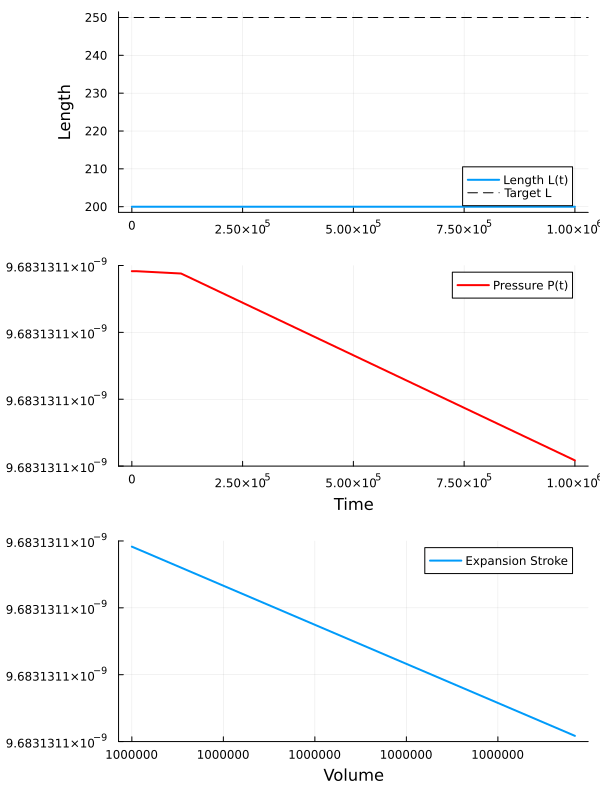

┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/HX80C/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/HX80C/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/HX80C/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/HX80C/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/HX80C/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/HX80C/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/HX80C/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/HX80C/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/HX80C/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/HX80C/src/ticks.jl:194
┌ Warning: No strict

In [25]:
process = "Expansion"

adiabatic_ode(
    avg_n,
    l0=l_min,
    v0=0.0,
    target_l=l_max,
    cavity=cavity,
    external_force=cavity.expanding_force,
    max_time=1000000.0
)